In [25]:
import pandas as pd
import csv
import os
import time
from collections import defaultdict
import numpy as np
import itertools
import db_structure
import networkx as nx
from imp import reload
import matplotlib.pyplot as plt
import utilities as u
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
db = db_structure.DB('sample1')
all_columns = db.columns
all_columns

[customers.customerNum & orders.customerNum & payments.customerNumber,
 employees.officeCode & offices.officeCode,
 orderdetails.productCode & products.productCode,
 orderdetails.orderNumber & orders.orderNumber,
 customers.employeeNumber & employees.employeeNumber,
 productlines.productLine & products.productLine,
 customers.LastName,
 customers.FirstName,
 employees.LastName,
 employees.FirstName,
 offices.State,
 orderdetails.quantity,
 orders.orderDate,
 orders.Status,
 payments.checkNumber,
 payments.amount,
 productlines.TextDesc,
 products.productDescription]

In [35]:
column_label_to_obj

{'siteid_[PHYSIOSTATUS]': Column siteid in tables {PHYSIOSTATUS},
 'Occurrence_[PHYSIOSTATUS]': Column Occurrence in tables {PHYSIOSTATUS},
 'FormStatus_[PHYSIOSTATUS]': Column FormStatus in tables {PHYSIOSTATUS},
 'ItemGroupRepeatKey_[PHYSIOSTATUS]': Column ItemGroupRepeatKey in tables {PHYSIOSTATUS},
 'LowpH': Column LowpH in tables {PHYSIOSTATUS},
 'HighpH': Column HighpH in tables {PHYSIOSTATUS},
 'pHND': Column pHND in tables {PHYSIOSTATUS},
 'HighPCO2': Column HighPCO2 in tables {PHYSIOSTATUS},
 'PCO2ND': Column PCO2ND in tables {PHYSIOSTATUS},
 'LowPa02': Column LowPa02 in tables {PHYSIOSTATUS},
 'PaO2ND': Column PaO2ND in tables {PHYSIOSTATUS},
 'LowIonCalcium': Column LowIonCalcium in tables {PHYSIOSTATUS},
 'HighIonCalcium': Column HighIonCalcium in tables {PHYSIOSTATUS},
 'IonCalciumND': Column IonCalciumND in tables {PHYSIOSTATUS},
 'LowSodium': Column LowSodium in tables {PHYSIOSTATUS},
 'HighSodium': Column HighSodium in tables {PHYSIOSTATUS},
 'SodiumND': Column SodiumND

In [28]:
table_1.df

,col1_[A],col2_[A],col3_[A]
0,1,A,3
1,1,A,4
2,1,B,5
3,2,B,6
4,2,C,7
5,2,C,8


In [29]:
table_2.df

,col3_[B],col4_[B]
0,2,A
1,3,B
2,4,C
3,5,C
4,6,C
5,7,D
6,8,D


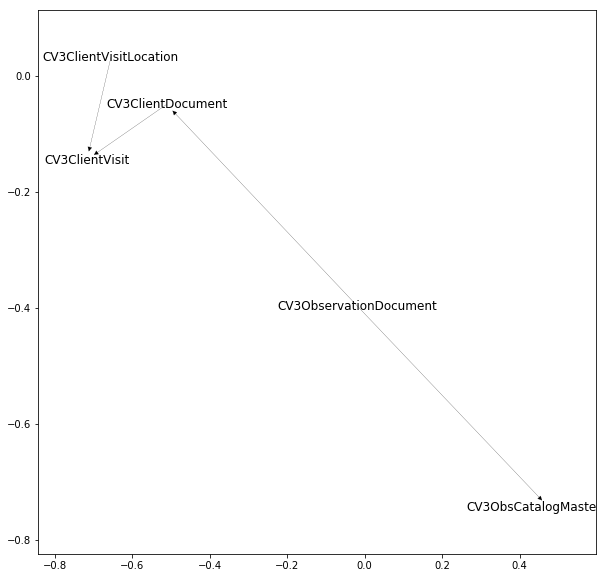

In [17]:
G = nx.DiGraph()
G.add_nodes_from(DB.tables.keys())
for current_table_name, current_table in DB.tables.items():
    for sibling in current_table.get_sibling_names():
        G.add_edge(current_table_name, sibling)
        G.add_edge(sibling, current_table_name)
    for child in current_table.get_children_names():
        G.add_edge(current_table_name, child)
plt.figure(figsize=(10,10))

#draw with networkx built-ins
nx.draw_networkx(G, node_shape="None", width=0.2)

#OR

#draw using pygraphviz
#A = nx.nx_agraph.to_agraph(G)
#H = nx.nx_agraph.from_agraph(A)
#nx.draw_spring(H, node_shape="None", with_labels=True, width=0.2)